# 💻 Kartprojeksjoner

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GMGI221-2024/forelesninger/blob/main/04_projeksjoner.ipynb)

Et **koordinatsystem (CRS)** er en avgjørende del av metadata for ethvert
geografisk datasett. Uten et CRS, ville geometriene ganske enkelt være en samling
av koordinater i et vilkårlig rom. Bare CRS tillater GIS-programvare,
inkludert Python-pakkene vi bruker i dette kurset, å relatere disse
koordinatene til et sted på jorden (eller andre omtrent sfæriske objekter eller
planeter).

Ofte sammenlignet med koordinatreferansesystemer, og definitivt nært
relatert, er **kartprojeksjoner**. Kartprojeksjoner, også kalt *projiserte
koordinatsystemer*, er matematiske modeller som lar oss overføre
koordinater på overflaten av vår **tredimensjonale jord** til koordinater
i en plan overflate, som et **flatt, todimensjonalt kart**. I motsetning til
projiserte koordinatsystemer, bruker *geografiske koordinatsystemer* rett og slett direkte
bredde- og lengdegrad, dvs. gradene langs de horisontale og vertikale store sirklene til en sfære som tilnærmer jorden, som x- og y-koordinater
i et plant kart. Til slutt er det både projiserte og geografiske koordinatsystemer som bruker mer komplekse ellipsoider enn en enkel sfære for å bedre
tilnærme 'potetformen' som planeten vår har. Den fulle CRS-informasjonen er
nødvendig for å nøyaktig kunne relatere geografisk informasjon til et sted på jorden og inkluderer
både (projiserte/geografiske) koordinatsystem og ellipsoider.

CRS i forskjellige romlige datasett varierer ganske ofte, da forskjellige
koordinatsystemer er optimalisert for bestemte regioner og formål. Ingen
koordinatsystem kan være perfekt nøyaktig rundt hele kloden, og
transformasjonen fra tre- til todimensjonale koordinater kan ikke være nøyaktig
i vinkler, avstander og områder samtidig.

Følgelig er det en vanlig GIS-oppgave å **transformere** (eller reprosjektere) et datasett
fra ett referansesystem til et annet, for eksempel, for å gjøre to lag interoperable. Sammenligning av to datasett som har forskjellige CRS vil
uunngåelig måtte produsere feil resultater; for eksempel, å finne punkter inneholdt i et
polygon kan ikke fungere, hvis punktene har geografiske koordinater (i
grader), og polygonet er i det nasjonale norske referansesystemet (i
meter).

Å velge en passende projeksjon for kartet ditt er ikke alltid enkelt.
Det avhenger av hva du faktisk vil representere i kartet ditt, og hvilke
romlige skala, oppløsning og utstrekning dataene dine har. Faktisk er det ikke en enkelt
'perfekt projeksjon'; hver har styrker og svakheter, og du bør velge
en projeksjon som passer best for hvert kart. Faktisk kan projeksjonen du velger
kanskje til og med fortelle noe om deg:


:::{figure} https://imgs.xkcd.com/comics/map_projections.png

*Source: [xkcd.com](https://xkcd.com/977)*

:::

:::{note}

For de av dere som foretrekker en mer analytisk tilnærming til å velge kart
projeksjoner: du kan få en god oversikt fra
[georeference.org](http://www.georeference.org/doc/guide_to_selecting_map_projections.htm),
og dette blogginnlegget som diskuterer [styrkene og svakhetene til noen vanlig
brukte projeksjoner](http://usersguidetotheuniverse.com/index.php/2011/03/03/whats-the-best-map-projection/).
Nettsiden *Radical Cartography* har en utmerket [oversikt over hvilke
projeksjoner som passer hvilke utstrekninger av verden for hvilket
emne](https://radicalcartography.net/projectionref.html).

:::


---


## Håndtering av koordinatreferansesystemer i Geopandas

Når du har funnet ut hvilken kartprojeksjon du skal bruke, er håndtering av koordinatreferansesystemer, heldigvis, ganske enkelt i Geopandas. Biblioteket
[pyproj](https://pyproj4.github.io/pyproj/) gir ytterligere informasjon
om et CRS, og kan hjelpe med mer vanskelige oppgaver, som å gjette det
ukjente CRS-et til et datasett.

I denne delen vil vi lære **hvordan hente ut informasjon om koordinatreferansesystemet
fra et datasett, og hvordan du re-projiserer dataene til et annet CRS**. 


:::{admonition} Vær forsiktig med Shapefiler
:class: caution

Du har kanskje lagt merke til at geografiske datasett i *ESRI Shapefile* format 
består av flere filer med forskjellige filutvidelser. `.prj`-filen
inneholder informasjon om koordinatreferansesystemet. Pass på at du ikke
mister den!
:::

### Vise CRS av et datasett

Vi starter med å laste inn et datasett med EU-land som er lastet ned
fra [*Geographic Information System of the Commission*
(GISCO)](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/countries), en enhet innenfor Eurostat som håndterer geografiske data for den europeiske
kommisjonen.

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_MAPPE = NOTEBOOK_PATH / "data"

In [4]:
import geopandas

eu_land = geopandas.read_file(
    DATA_MAPPE / "eu_countries" / "eu_countries_2022.gpkg"
)

La oss sjekke datasettets CRS:

In [5]:
eu_land.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Det vi ser her er faktisk et `pyproj.CRS` objekt. 

EPSG-koden (*European Petroleum Survey Group*) er global standard for
identifisering av koordinatreferansesystemer. Tallet refererer til en oppføring i
[EPSG Geodetic Parameter Dataset](http://www.epsg.org/), en samling av
koordinatreferansesystemer koordinattransformasjoner som spenner fra globalt til
nasjonalt, regionalt og lokalt omfang.

Vårt `GeoDataFrame` EPSG-kode er `4326`. Dette er et tall å huske, da du
vil komme over det mye i den geografiske verden: Det refererer til et geografisk
koordinatsystem som bruker WGS-84-referanseellipsoiden. Dette er det mest
vanlig brukte koordinatreferansesystemet i verden. Det er det vi refererer til
når vi snakker om lengde- og breddegrad.

Du kan finne informasjon om referansesystemer og lister over kjent
CRS fra mange online ressurser, for eksempel:
- [spatialreference.org](http://spatialreference.org/)
- [proj4.org](https://proj4.org/operations/projections/)
- [mapref.org](http://mapref.org/CollectionofCRSinEurope.html)


:::{tip}

Hvis du vet hvilken rekkevidde koordinatverdiene skal være i, skader det ikke å ta en rask titt på dataene selv. I tilfellet `EPSG:4326`, bør koordinatene være mellom -180 og 180° lengdegrad og -90 og 90° breddegrad.
:::

In [6]:
eu_land.geometry.head()

0    MULTIPOLYGON (((13.68400 46.43750, 13.51100 46...
1    MULTIPOLYGON (((6.31560 50.49700, 6.40500 50.3...
2    MULTIPOLYGON (((28.49800 43.43410, 28.06020 43...
3    MULTIPOLYGON (((16.94980 48.53580, 16.85110 48...
4    MULTIPOLYGON (((32.94170 34.64180, 32.55900 34...
Name: geometry, dtype: geometry

Faktisk ser koordinatverdiene i datasettet vårt ut til å være i en passende verdiområde.


---


### Reprojisere en `GeoDataFrame` 

Et geografisk koordinatsystem, `EPSG:4326`, er ikke spesielt godt egnet
for å vise landene i Den europeiske union. Forvrengningen er høy. Snarere kunne vi
bruke en *Lambert Azimuthal Equal-Area* projeksjon, som
[`EPSG:3035`](https://spatialreference.org/ref/epsg/etrs89-etrs-laea/), kartprojeksjonen [offisielt anbefalt av den europeiske
kommisjonen](http://mapref.org/LinkedDocuments/MapProjectionsForEurope-EUR-20120.pdf).

[Transformasjon av data fra ett referansesystem til et annet er en veldig enkel oppgave
i geopandas](http://geopandas.org/projections.html#re-projecting). Faktisk,
alt du må gjøre er å bruke `to_crs()` metoden til en `GeoDataFrame`, og levere
et nytt CRS i et bredt spekter av mulige formater. Det enkleste er å bruke en EPSG
kode:

In [7]:
eu_land_EPSG3035 = eu_land.to_crs("EPSG:3035")

La oss sjekke hvordan koordinatverdiene har endret seg:

In [8]:
eu_land_EPSG3035.geometry.head()

0    MULTIPOLYGON (((4604288.477 2598607.470, 45914...
1    MULTIPOLYGON (((4059689.242 3049361.180, 40650...
2    MULTIPOLYGON (((5805367.757 2442801.252, 57739...
3    MULTIPOLYGON (((4833567.363 2848881.974, 48272...
4    MULTIPOLYGON (((6413299.362 1602181.345, 63782...
Name: geometry, dtype: geometry

Og vipps, koordinatverdiene i geometriene har endret seg!
Gratulerer med å ha utført din aller første geopandas koordinat-transformasjon!

For bedre å forstå nøyaktig hva vi nettopp har gjort, er det en god idé å utforske
dataene våre visuelt. La oss tegne datasettet vårt både før og etter
koordinattransformasjon. Vi vil bruke `matplotlib` sin `subplots`-funksjon.

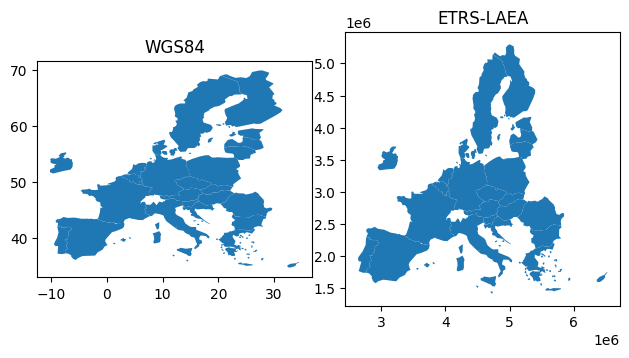

In [9]:
import matplotlib.pyplot

# Forbered subplots som er ved siden av hverandre
figure, (axis1, axis2) = matplotlib.pyplot.subplots(nrows=1, ncols=2)

# Plott det originale (WGS84, EPSG:4326) datasettet
eu_land.plot(ax=axis1)
axis1.set_title("WGS84")
axis1.set_aspect(1)

# Plott det reprojiserte (EPSG:3035) datasettet
eu_land_EPSG3035.plot(ax=axis2)
axis2.set_title("ETRS-LAEA")
axis2.set_aspect(1)

matplotlib.pyplot.tight_layout()

Faktisk ser kartene ganske forskjellige ut, og det reprojiserte datasettet forvrenger
de europeiske landene mindre, spesielt i den nordlige delen av kontinentet.

La oss fortsatt lagre det reprojiserte datasettet i en fil slik at vi kan bruke det senere.
Merk at, selv om moderne filformater lagrer CRS pålitelig, er det en god
idé å bruke et beskrivende filnavn som inkluderer referansesystem
informasjon.

In [12]:
eu_land_EPSG3035.to_file(
    DATA_MAPPE / "eu_countries" / "eu_land_EPSG3035.gpkg"
)

---

## Håndtering av forskjellige CRS-formater

Det er forskjellige måter å lagre og representere CRS-informasjon på. De mer brukte formatene inkluderer [PROJ
strenger](https://proj.org/usage/quickstart.html), EPSG-koder, *Well-Known-Text*
(WKT) og JSON. Du vil sannsynligvis støte på noen eller alle disse når du jobber
med romlige data hentet fra forskjellige kilder. Å kunne konvertere CRS-informasjon fra ett format til et annet er nødvendig nå og da, derfor er det
nyttig å vite noen triks for hvordan man gjør dette.

Vi har allerede kort nevnt at geopandas bruker
[pyproj](https://pyproj4.github.io/pyproj/)-biblioteket for å håndtere referansesystemer. Vi kan bruke den samme modulen for å analysere og konvertere CRS-informasjon i forskjellige formater.


### Oversikt

Nedenfor printer vi forskjellige representasjoner av CRS for datasettet med EU
land vi brukte før:

In [13]:
import pyproj

crs = pyproj.CRS(eu_land.crs)

print(f"CRS som en proj4-streng: {crs.to_proj4()}\n")

print(f"CRS i WKT-format: {crs.to_wkt()}\n")

print(f"EPSG-kode for CRS: {crs.to_epsg()}\n")

CRS som en proj4-streng: +proj=longlat +datum=WGS84 +no_defs +type=crs

CRS i WKT-format: GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]

EPSG-kode for CRS: 4326



/home/aagesenh/anaconda3/envs/py311/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


:::{note}

Ikke hvert mulig koordinatreferansesystem har en tilordnet EPSG-kode.
Derfor prøver *pyproj*, som standard, å finne den best matchende EPSG
definisjonen. Hvis den ikke finner noen, returnerer `to_epsg()` `None`.
:::

### Bruk pyproj for å finne detaljert informasjon om et CRS

Et `pyproj.CRS` objekt kan også initialiseres manuelt, for eksempel ved bruk av en
EPSG-kode eller en Proj4-streng. Den kan da gi detaljert informasjon om
parametrene for referansesystemet, samt foreslåtte bruksområder. Vi kan,
for eksempel, lage et `CRS` objekt for `EPSG:3035` kartprojeksjonen vi brukte
over:

In [14]:
crs = pyproj.CRS("EPSG:4326")
crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Umiddelbart ser vi at et `pyproj.CRS` objekt inneholder rik informasjon om
referansesystemet: et *navn*, et *bruksområde* (inkludert *grenser*), et
*datum* og en *ellipsoide*.

Denne informasjonen kan også trekkes ut individuelt:

In [15]:
crs.name

'WGS 84'

In [16]:
crs.area_of_use.bounds

(-180.0, -90.0, 180.0, 90.0)

---

# Globale kartprojeksjoner

Nå er det på tide å leke med noen kartprojeksjoner. For å gjøre dette finner du et globalt datasett med landpolygoner i datamappen. Det ble
lastet ned fra [naturalearthdata.com](https://naturalearthdata.com/), en
fantastisk ressurs for kartografi-geodata.


:::{admonition} Sjekk din forståelse
:class: attention

Les inn datasettet fra `DATA_MAPPE / "world_countries" /
"ne_110m_admin_0_countries.zip"` og plott tre kart med forskjellige kart
projeksjoner. Du kan bruke tips og definisjoner fra følgende ressurser
(og hvor som helst ellers):

- [geopandas.org/projections.html](http://geopandas.org/projections.html)
- [pyproj4.github.io](https://pyproj4.github.io/pyproj/dev/api/crs.html)
- [spatialreference.org](https://spatialreference.org/)

Under plotting av kartene og valg av kartprojeksjoner, tenk på
fordeler og ulemper med forskjellige kartprojeksjoner.
:::

In [18]:
verden = geopandas.read_file(
    DATA_MAPPE / "world_countries" / "ne_110m_admin_0_countries.zip"
)

Text(0.5, 1.0, 'WGS 84')

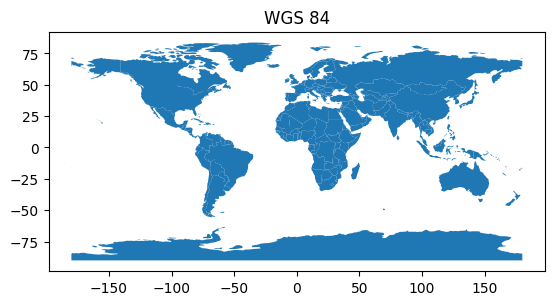

In [19]:
verden.plot()
matplotlib.pyplot.title(verden.crs.name)

(-22041259.17706817,
 22041259.177068174,
 -255577115.13568556,
 31488437.087057084)

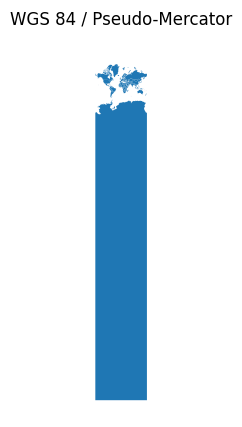

In [20]:
# web mercator
verden_EPSG3857 = verden.to_crs("EPSG:3857")

verden_EPSG3857.plot()
matplotlib.pyplot.title(verden_EPSG3857.crs.name)

# fjern akse dekorasjoner
matplotlib.pyplot.axis("off")

(-18321736.696081996,
 18321736.696081996,
 -9302420.503183275,
 9217598.414473996)

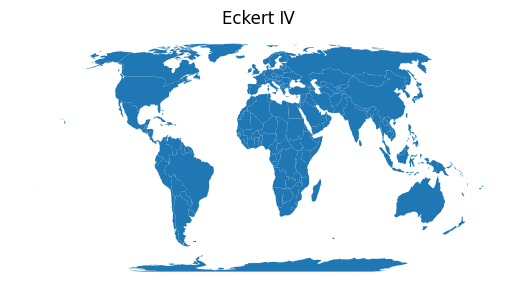

In [21]:
# Eckert-IV (https://spatialreference.org/ref/esri/54012/)
ECKERT_IV = "+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

verden_eckert_iv = verden.to_crs(ECKERT_IV)
verden_eckert_iv.plot()
matplotlib.pyplot.title("Eckert Ⅳ")
matplotlib.pyplot.axis("off")

(-7006995.416935118, 7005877.340582642, -6968264.187936907, 6378854.706416504)

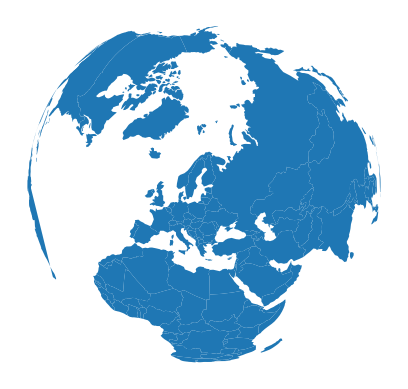

In [22]:
# En ortografisk projeksjon, sentrert i Finland!
# (http://www.statsmapsnpix.com/2019/09/globe-projections-and-insets-in-qgis.html)
verden_ortho = verden.to_crs(
    "+proj=ortho +lat_0=60.00 +lon_0=23.0000 +x_0=0 +y_0=0 "
    "+a=6370997 +b=6370997 +units=m +no_defs"
)
verden_ortho.plot()
matplotlib.pyplot.axis("off")